## 1. Load data

In [1]:
import numpy as np
from Library.signal_target import SignalAndTarget
import scipy.io as sio

In [2]:
# Dataset
train_dict = sio.loadmat(r'/data/yiwang/DEAP_10_iterations_3D/Train_data_and_labels_3d.mat')
test_dict = sio.loadmat(r'/data/yiwang/DEAP_10_iterations_3D/Test_data_and_labels_3d.mat')

# Load Valence Data&Label for training and testing
train_valence_data = train_dict['train_valence_data_balanced_3d']
train_valence_label = train_dict['train_valence_label_balanced']
test_valence_data = test_dict['test_valence_data_3d']
test_valence_label = test_dict['test_valence_label']

# Type
train_valence_data = train_valence_data.astype(np.float32)
train_valence_label = train_valence_label.astype(np.int64)
test_valence_data = test_valence_data.astype(np.float32)
test_valence_label = test_valence_label.astype(np.int64)

# Shape
train_valence_label.shape = (train_valence_label.shape[0],)
test_valence_label.shape = (test_valence_label.shape[0],)

# Form train and test set
train_set = SignalAndTarget(train_valence_data, y=train_valence_label)
test_set = SignalAndTarget(test_valence_data, y=test_valence_label)

------

## 2. Create the model, optimizer, iterator

In [3]:
from Library_3D.EmotionRecognition import EmotioNet                                             
from torch import nn
from Library.torch_ext_util import set_random_seeds
from Library.models_util import to_dense_prediction_model

In [4]:
cuda = True

# set seeds for generating random numbers for torch, CUDA and numpy
set_random_seeds(seed=19890516, cuda=cuda)                                                      

In [5]:
input_time_length = 450

model = EmotioNet(in_chans=32, n_classes=2, input_time_length=input_time_length,                
                 final_conv_length=1).create_network()
# final_conv_length determines the size of the receptive field of the ConvNet

In [6]:
if cuda:
    model.cuda()  # moves all model parameters and buffers to the GPU

from torch import optim
optimizer = optim.Adam(model.parameters())

In [7]:
from Library.torch_ext_util import np_to_var

batch_size = 10
test_input = np_to_var(np.ones((batch_size, 7, 9, input_time_length, 1), dtype=np.float32))
if cuda:
    test_input = test_input.cuda()

out = model(test_input)

n_preds_per_input = out.cpu().data.numpy().shape[2]
print("{:d} predictions per input/trial".format(n_preds_per_input))

396 predictions per input/trial


/home/cshome/d/davidwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [8]:
from Library_3D.iterators_for_3d import CropsFromTrialsIterator
iterator = CropsFromTrialsIterator(batch_size=10,input_time_length=input_time_length,
                                  n_preds_per_input=n_preds_per_input)

## 3. Training and Testing

In [9]:
from Library.torch_ext_util import np_to_var, var_to_np
import torch.nn.functional as F
from numpy.random import RandomState
import torch as th
from Library_3D.monitors_3d import compute_preds_per_trial_for_set

#---plot 1
train_loss_list=[]
test_loss_list=[]
#---plot 2
train_accuracy_list=[]
test_accuracy_list=[]

# Calculate the initial loss and accuracy.
model.eval()
for setname, dataset in (('Train', train_set),('Test', test_set)):
    # Collect all predictions and losses
    all_preds = []
    all_losses = []
    batch_sizes = []

    for batch_X, batch_y in iterator.get_batches(dataset, shuffle=False):     
        net_in = np_to_var(batch_X)
        if cuda:
            net_in = net_in.cuda()

        net_target = np_to_var(batch_y)
        if cuda:
            net_target = net_target.cuda()

        outputs = model(net_in)
        # output shape = (10, 2, 78)

        all_preds.append(var_to_np(outputs))

        outputs = th.mean(outputs, dim=2, keepdim=False)
        # output shape = (10, 2)
        loss = F.nll_loss(outputs, net_target)
        loss = float(var_to_np(loss))
        all_losses.append(loss)

        batch_sizes.append(len(batch_X))

    # outputs of the for loop:
    # all_preds = [np.array() shape=(30, 2, 345),  ...] for all batches
    # all_losses = [np.array() shape=(30,), ...] for all batches
    # batch_sizes = [30, 30, ...]

    print ("Initialization...")
    loss = np.mean(np.array(all_losses) * np.array(batch_sizes) / np.mean(batch_sizes))
    print("{:6s} Loss: {:.5f}".format(setname, loss))

    preds_per_trial = compute_preds_per_trial_for_set(all_preds,
                                                      input_time_length,
                                                      dataset)

    meaned_preds_per_trial = np.array([np.mean(p, axis=1) for p in preds_per_trial])
    # print (meaned_preds_per_trial.shape) = (1080, 2) for training，(200, 2) for testing 

    predicted_labels = np.argmax(meaned_preds_per_trial, axis=1)
    accuracy = np.mean(predicted_labels == dataset.y)
    print("{:6s} Accuracy: {:.1f}%".format(setname, accuracy * 100))
       
    if setname=='Train':
        train_loss_list.append(loss)
        train_accuracy_list.append(accuracy)
    if setname=='Test':
        test_loss_list.append(loss)
        test_accuracy_list.append(accuracy)

# Training and testing, output performance on training and testing for each epoch
rng = RandomState((2017,10,25))                                                                 
for i_epoch in range(10):                                                                       
    print("Epoch {:d}".format(i_epoch))
    print("Train....")

    model.train()    
    for batch_X, batch_y in iterator.get_batches(train_set, shuffle=True): 
        # print (batch_X.shape)  (10, 32, 450, 1)
        # print (batch_y.shape)  (10,)
        
        net_in = np_to_var(batch_X)
        if cuda:
            net_in = net_in.cuda()
        
        net_target = np_to_var(batch_y)
        if cuda:
            net_target = net_target.cuda()
        
        # Remove gradients of last backward pass from all parameters 
        optimizer.zero_grad()
        
        outputs = model(net_in)
        # output shape = (10, 2, 345)
        # print (outputs.cpu().data.numpy()[0,:,:])
        
        outputs = th.mean(outputs, dim=2, keepdim=False)
        # Mean predictions across trial (over 345), ouput shape = (10,2)
        # net_target shape = (10,), value = 0 or 1
             
        loss = F.nll_loss(outputs, net_target)
        loss.backward()
        optimizer.step() 
    
    model.eval()
    for setname, dataset in (('Train', train_set),('Test', test_set)):
        all_preds = []
        all_losses = []
        batch_sizes = []
        
        for batch_X, batch_y in iterator.get_batches(dataset, shuffle=False):           
            net_in = np_to_var(batch_X)
            if cuda:
                net_in = net_in.cuda()
                
            net_target = np_to_var(batch_y)
            if cuda:
                net_target = net_target.cuda()
                
            outputs = model(net_in)
            # output shape = (30, 2, 345)
            
            all_preds.append(var_to_np(outputs))
            
            outputs = th.mean(outputs, dim=2, keepdim=False)
            # output shape = (30, 2)
            loss = F.nll_loss(outputs, net_target)
            loss = float(var_to_np(loss))
            all_losses.append(loss)
            
            batch_sizes.append(len(batch_X))
        
        # outputs of the for loop:
        # all_preds = [np.array() shape=(30, 2, 345),  ...] for all batches
        # all_losses = [np.array() shape=(30,), ...] for all batches
        # batch_sizes = [30, 30, ...]
        
        # Compute mean per-input loss 
        loss = np.mean(np.array(all_losses) * np.array(batch_sizes) / np.mean(batch_sizes))
        print("{:6s} Loss: {:.5f}".format(setname, loss))
        

        
        preds_per_trial = compute_preds_per_trial_for_set(all_preds,
                                                          input_time_length,
                                                          dataset)    
        # Now mean across timesteps for each trial to get per-trial predictions
        meaned_preds_per_trial = np.array([np.mean(p, axis=1) for p in preds_per_trial])
        # print (meaned_preds_per_trial.shape) = (1080, 2) for training，(200, 2) for testing       
        predicted_labels = np.argmax(meaned_preds_per_trial, axis=1)

        accuracy = np.mean(predicted_labels == dataset.y)
        print("{:6s} Accuracy: {:.1f}%".format(setname, accuracy * 100))
     
        # -----
        if setname=='Train':
            train_loss_list.append(loss)
            train_accuracy_list.append(accuracy)
        if setname=='Test':
            test_loss_list.append(loss)
            test_accuracy_list.append(accuracy)

/home/cshome/d/davidwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Initialization...
Train  Loss: 0.98158
Train  Accuracy: 50.0%
Initialization...
Test   Loss: 1.21702
Test   Accuracy: 20.0%
Epoch 0
Train....
Train  Loss: 0.55685
Train  Accuracy: 71.5%
Test   Loss: 0.65225
Test   Accuracy: 58.0%
Epoch 1
Train....
Train  Loss: 0.55139
Train  Accuracy: 70.9%
Test   Loss: 0.67411
Test   Accuracy: 68.0%
Epoch 2
Train....
Train  Loss: 0.52835
Train  Accuracy: 72.2%
Test   Loss: 0.66110
Test   Accuracy: 58.0%
Epoch 3
Train....
Train  Loss: 0.52490
Train  Accuracy: 72.2%
Test   Loss: 0.63011
Test   Accuracy: 74.0%
Epoch 4
Train....
Train  Loss: 0.53555
Train  Accuracy: 72.1%
Test   Loss: 0.64509
Test   Accuracy: 70.0%
Epoch 5
Train....
Train  Loss: 0.53427
Train  Accuracy: 73.8%
Test   Loss: 0.69349
Test   Accuracy: 50.0%
Epoch 6
Train....
Train  Loss: 0.52264
Train  Accuracy: 72.7%
Test   Loss: 0.61924
Test   Accuracy: 80.0%
Epoch 7
Train....
Train  Loss: 0.53613
Train  Accuracy: 73.2%
Test   Loss: 0.56043
Test   Accuracy: 80.0%
Epoch 8
Train....
Train  Los

In [10]:
import matplotlib.pyplot as plt

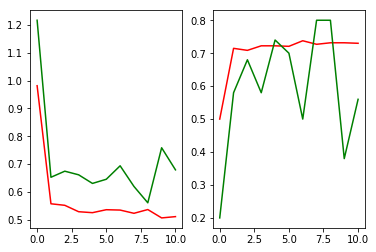

In [11]:
plt.subplot(1,2,1)
plt.plot(train_loss_list, 'r', label='train loss')
plt.plot(test_loss_list, 'g', label='test loss')

plt.subplot(1,2,2)
plt.plot(train_accuracy_list, 'r', label='train acc')
plt.plot(test_accuracy_list, 'g', label='test acc')

plt.show()